In [11]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from keras.models import load_model

In [99]:
import sys
sys.path.append('..')

from utils import read_pickle, dump_pickle
from rectangles_drawing import calculate_one_pixels_diffs
from osm_object import Image_OSM_object

from circle_diagram import calculate_sectors_count, create_circle_diagram
from circle_diagram import Image_circle_diagrams
from circle_diagram import calculate_penalty_for_diagrams

### Изображение и точка

In [4]:
img_id = '10818'
point = (231, 316)

In [5]:
image_path = '../dataset/satellite/' + img_id + '.png'

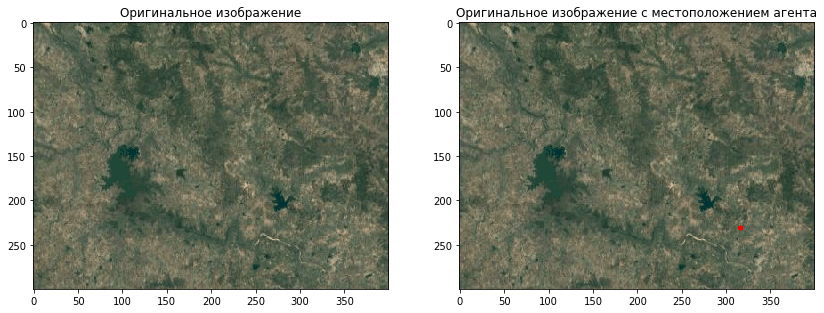

In [6]:
plt.figure(figsize=(14, 7))
    
plt.subplot(121)
img = cv2.imread(image_path)
plt.title('Оригинальное изображение')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(122)
img_copy = img.copy()
cv2.circle(img_copy, (point[1], point[0]), 3, (0, 0, 255), -1) 
plt.title('Оригинальное изображение с местоположением агента')
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))


plt.show()

### Выделение потенциальных ориентиров

In [34]:
corners_folder = '../dataset/corners'
H, W = 300, 400
img_shape = (H, W)

THRESH_WOOD = 0.15
THRESH_WATER = 0.15
THRESH_PEAK = 0.08

TMP_FOLDER = 'TMP_FOR_EXAMPLE'

In [8]:
def predict_one(autoencoder, img, thresh):
    return autoencoder.predict(np.array([img / 255.]).reshape(([1] + list(img.shape))))[0] >= thresh


def mask_to_rectangles(mask):
    visited = np.zeros(mask.shape[:2], dtype=int)
    queue = []
    rectangles = []
    
    queue_idx = 0

    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            # первая непосещённая вершина
            if visited[x][y] == 0 and mask[x][y]:
                cur_vertex = (x, y)
            else:
                continue
        
            queue.append(cur_vertex)
        
            def bfs(queue_idx):
                min_x, max_x, min_y, max_y = None, None, None, None

                while len(queue) != queue_idx:
                    v = queue[queue_idx]
                    queue_idx += 1

                    x, y = v
                    if visited[x][y] == 1:
                        continue
                    visited[x][y] = 1

                    if min_x is None or x < min_x:
                        min_x = x
                    if max_x is None or x > max_x:
                        max_x = x
                    if min_y is None or y < min_y:
                        min_y = y
                    if max_y is None or y > max_y:
                        max_y = y

                    # рассматриваем все соседние непосещённые вершины
                    left = (x, y - 1)
                    right = (x, y + 1)
                    top = (x - 1, y)
                    bottom = (x + 1, y)

                    def visit_vertex(x, y):
                        if x >= 0 and y >= 0 and x < mask.shape[0] and y < mask.shape[1] and visited[x][y] == 0\
                            and mask[x][y]:
                                queue.append((x, y))

                    visit_vertex(*left)
                    visit_vertex(*right)
                    visit_vertex(*top)
                    visit_vertex(*bottom)

                return queue_idx, queue, visited, min_x, max_x, min_y, max_y

            queue_idx, queue, visited, min_x, max_x, min_y, max_y = bfs(queue_idx)
            if min_x is not None and max_x is not None and min_y is not None and max_y is not None:
                rectangles.append((min_x, max_x, min_y, max_y))

    return rectangles


def rectangle_to_coords(rectangle, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon):
    x1, x2, y1, y2 = rectangle
    
    one_pixel_lat_diff, one_pixel_lon_diff = calculate_one_pixels_diffs(right_top_lat, right_top_lon, 
                                                                    left_bottom_lat, left_bottom_lon, (H, W))
    
    minlat = right_top_lat - (x2 * one_pixel_lat_diff)
    maxlat = right_top_lat - (x1 * one_pixel_lat_diff)
    minlon = left_bottom_lon + (y1 * one_pixel_lon_diff)
    maxlon = left_bottom_lon + (y2 * one_pixel_lon_diff)
    
    return minlat, maxlat, minlon, maxlon

In [9]:
def predict_one_img(img, img_id, class_id, autoencoder, thresh, class_name):
    
    filename_pickle = img_id + '.pickle'

    corners = read_pickle(os.path.join(corners_folder, filename_pickle))
    right_top_lat = corners['right_top_lat']
    right_top_lon = corners['right_top_lon']
    left_bottom_lat = corners['left_bottom_lat']
    left_bottom_lon = corners['left_bottom_lon']
    
    satellite_img = img.copy()
    
    mask_pred = predict_one(autoencoder, satellite_img, thresh)
    
    rectangles = mask_to_rectangles(mask_pred)
    
    bounds = []
    tags = []
    
    # теперь каждый прямоугольник нужно преобразовать в minlat, maxlat, minlon, maxlon
    for r in rectangles:
        minlat, maxlat, minlon, maxlon = rectangle_to_coords(r, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon)
        bounds.append({'maxlon': maxlon, 'minlat': minlat, 'minlon': minlon, 'maxlat': maxlat})
        tags.append(class_name)
        
    return bounds, tags, mask_pred, rectangles

In [2]:
%%time
autoencoder_wood = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_wood_satellite.h5'))













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


CPU times: user 2.73 s, sys: 845 ms, total: 3.57 s
Wall time: 6.21 s


In [16]:
%%time
bounds_wood, tags_wood, mask_pred_wood, rectangles_wood = predict_one_img(
    img,
    img_id,
    class_id=0,
    autoencoder=autoencoder_wood,
    thresh=THRESH_WOOD,
    class_name='wood'
)

CPU times: user 306 ms, sys: 7.39 ms, total: 314 ms
Wall time: 159 ms


In [19]:
print(len(bounds_wood))
print(tags_wood)
print(mask_pred_wood.shape)
print(rectangles_wood)

12
['wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood']
(300, 400, 1)
[(0, 38, 162, 195), (6, 19, 102, 120), (26, 48, 87, 111), (51, 108, 116, 172), (91, 105, 271, 284), (111, 148, 195, 210), (139, 152, 287, 319), (149, 225, 84, 143), (149, 200, 364, 382), (208, 224, 397, 398), (218, 228, 147, 166), (298, 298, 0, 1)]


In [22]:
# Сохранение
np.save(os.path.join(TMP_FOLDER, 'mask_wood.npy'), mask_pred_wood)
dump_pickle(os.path.join(TMP_FOLDER, 'bounds_wood.pickle'), bounds_wood)
dump_pickle(os.path.join(TMP_FOLDER, 'tags_wood.pickle'), tags_wood)
dump_pickle(os.path.join(TMP_FOLDER, 'rectangles_wood.pickle'), rectangles_wood)

In [23]:
del autoencoder_wood

In [26]:
%%time
autoencoder_water = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_water_satellite.h5'))

CPU times: user 908 ms, sys: 18.2 ms, total: 926 ms
Wall time: 916 ms


In [27]:
%%time
bounds_water, tags_water, mask_pred_water, rectangles_water = predict_one_img(
    img,
    img_id,
    class_id=1,
    autoencoder=autoencoder_water,
    thresh=THRESH_WATER,
    class_name='water'
)

print(len(bounds_water))
print(tags_water)
print(mask_pred_water.shape)
print(rectangles_water)

# Сохранение
np.save(os.path.join(TMP_FOLDER, 'mask_water.npy'), mask_pred_water)
dump_pickle(os.path.join(TMP_FOLDER, 'bounds_water.pickle'), bounds_water)
dump_pickle(os.path.join(TMP_FOLDER, 'tags_water.pickle'), tags_water)
dump_pickle(os.path.join(TMP_FOLDER, 'rectangles_water.pickle'), rectangles_water)

22
['water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water']
(300, 400, 1)
[(10, 15, 55, 56), (11, 43, 23, 52), (14, 28, 376, 388), (23, 36, 335, 374), (43, 67, 50, 64), (56, 56, 235, 235), (59, 77, 368, 392), (133, 194, 78, 126), (142, 152, 279, 288), (172, 172, 124, 124), (172, 176, 126, 132), (176, 218, 254, 294), (185, 187, 358, 360), (191, 191, 295, 295), (191, 193, 331, 332), (212, 245, 135, 204), (220, 225, 115, 116), (227, 231, 79, 83), (227, 251, 210, 236), (252, 256, 296, 299), (258, 284, 242, 258), (267, 267, 303, 303)]
CPU times: user 427 ms, sys: 7.94 ms, total: 435 ms
Wall time: 234 ms


In [28]:
del autoencoder_water

In [29]:
%%time
autoencoder_peak = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_peak_satellite.h5'))

CPU times: user 1.07 s, sys: 3.45 ms, total: 1.07 s
Wall time: 1.08 s


In [30]:
%%time
bounds_peak, tags_peak, mask_pred_peak, rectangles_peak = predict_one_img(
    img,
    img_id,
    class_id=3,
    autoencoder=autoencoder_peak,
    thresh=THRESH_PEAK,
    class_name='peak'
)

print(len(bounds_peak))
print(tags_peak)
print(mask_pred_peak.shape)
print(rectangles_peak)

# Сохранение
np.save(os.path.join(TMP_FOLDER, 'mask_peak.npy'), mask_pred_peak)
dump_pickle(os.path.join(TMP_FOLDER, 'bounds_peak.pickle'), bounds_peak)
dump_pickle(os.path.join(TMP_FOLDER, 'tags_peak.pickle'), tags_peak)
dump_pickle(os.path.join(TMP_FOLDER, 'rectangles_peak.pickle'), rectangles_peak)

0
[]
(300, 400, 1)
[]
CPU times: user 418 ms, sys: 7.95 ms, total: 426 ms
Wall time: 227 ms


In [31]:
del autoencoder_peak

In [32]:
# Объединение отдельных bounds и tags

# Загрузка
bounds_wood = read_pickle(os.path.join(TMP_FOLDER, 'bounds_wood.pickle'))
bounds_water = read_pickle(os.path.join(TMP_FOLDER, 'bounds_water.pickle'))
bounds_peak = read_pickle(os.path.join(TMP_FOLDER, 'bounds_peak.pickle'))
tags_wood = read_pickle(os.path.join(TMP_FOLDER, 'tags_wood.pickle'))
tags_water = read_pickle(os.path.join(TMP_FOLDER, 'tags_water.pickle'))
tags_peak = read_pickle(os.path.join(TMP_FOLDER, 'tags_peak.pickle'))


# Объединение
objects = bounds_wood + bounds_water + bounds_peak
tags = tags_wood + tags_water + tags_peak


# Сохранение объединённых
dump_pickle(os.path.join(TMP_FOLDER, 'objects_and_tags.pickle'), {'objects': objects, 'tags': tags})

#### Маски

In [33]:
mask_wood = np.load(os.path.join(TMP_FOLDER, 'mask_wood.npy'))
mask_water = np.load(os.path.join(TMP_FOLDER, 'mask_water.npy'))
mask_peak = np.load(os.path.join(TMP_FOLDER, 'mask_peak.npy'))

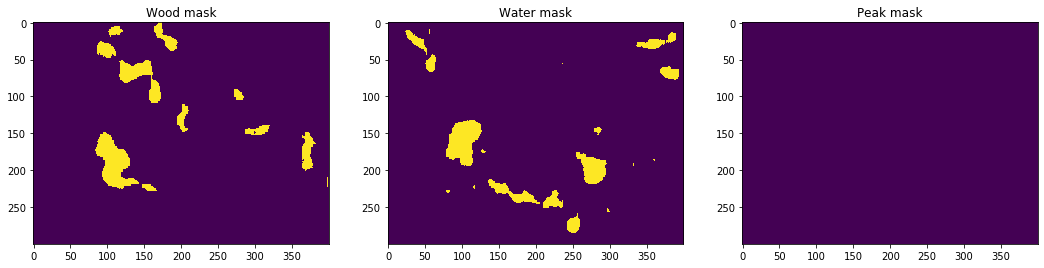

In [40]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.imshow(mask_wood.reshape(img_shape))
plt.title('Wood mask')

plt.subplot(132)
plt.imshow(mask_water.reshape(img_shape))
plt.title('Water mask')

plt.subplot(133)
plt.imshow(mask_peak.reshape(img_shape))
plt.title('Peak mask')

plt.show()

#### Прямоугольные границы

In [41]:
rectangles_wood = read_pickle(os.path.join(TMP_FOLDER, 'rectangles_wood.pickle'))
rectangles_water = read_pickle(os.path.join(TMP_FOLDER, 'rectangles_water.pickle'))
rectangles_peak = read_pickle(os.path.join(TMP_FOLDER, 'rectangles_peak.pickle'))

In [42]:
def rectangled_mask(rectangles, mask):
    mask_copy = mask.copy()
    for x1, x2, y1, y2 in rectangles:
        mask_copy[x1:x2+1, y1:y2+1] = 1
    return mask_copy

In [45]:
rectangled_mask_wood = rectangled_mask(rectangles_wood, mask_wood)
rectangled_mask_water = rectangled_mask(rectangles_water, mask_water)
rectangled_mask_peak = rectangled_mask(rectangles_peak, mask_peak)

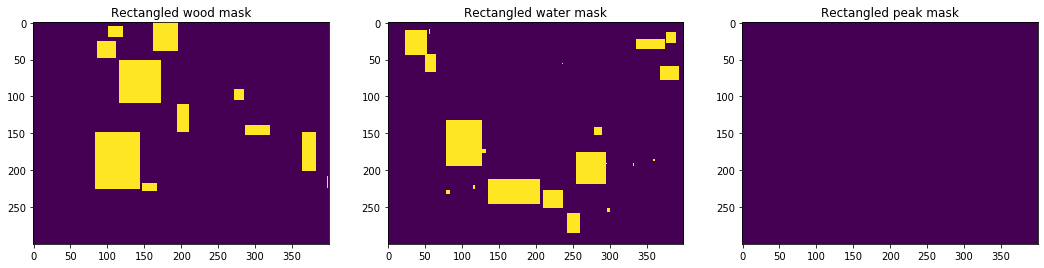

In [46]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.imshow(rectangled_mask_wood.reshape(img_shape))
plt.title('Rectangled wood mask')

plt.subplot(132)
plt.imshow(rectangled_mask_water.reshape(img_shape))
plt.title('Rectangled water mask')

plt.subplot(133)
plt.imshow(rectangled_mask_peak.reshape(img_shape))
plt.title('Rectangled peak mask')

plt.show()

#### Технический osm объект

In [52]:
filename_pickle = img_id + '.pickle'

corners = read_pickle(os.path.join(corners_folder, filename_pickle))
objects_and_tags = read_pickle(os.path.join(TMP_FOLDER, 'objects_and_tags.pickle'))
tags = objects_and_tags['tags']
bounds = objects_and_tags['objects']

right_top_lat = corners['right_top_lat']
right_top_lon = corners['right_top_lon']
left_bottom_lat = corners['left_bottom_lat']
left_bottom_lon = corners['left_bottom_lon']

img_osm = Image_OSM_object(
    img_shape,
    right_top_lat,
    right_top_lon,
    left_bottom_lat,
    left_bottom_lon,
    bounds,
    tags
)

In [53]:
dump_pickle(os.path.join(TMP_FOLDER, 'img_osm.pickle'), img_osm)

#### Оригинальная картинка с прямоугольными границами

In [55]:
def get_all_objects_and_tags(img_osm_object):
    return [(o.tag, o.minlon, o.maxlat, o.maxlon, o.minlat) for o in img_osm_object.osm_objects]

In [187]:
objects_and_tags = get_all_objects_and_tags(img_osm)

img_copy = img.copy()
    
for obj_type, x_min, y_min, x_max, y_max in objects_and_tags:
    if obj_type == 'wood':
        cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
    if obj_type == 'water':
        cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)
    if obj_type == 'peak':
        cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color=(0, 255, 255), thickness=2)

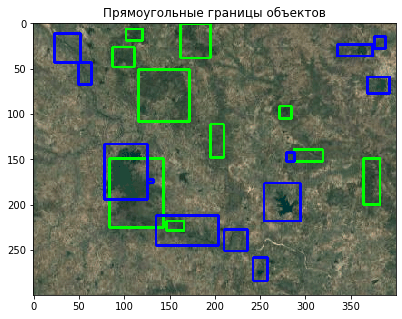

In [188]:
plt.figure(figsize=(11, 5))

plt.title('Прямоугольные границы объектов')
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))

plt.show()

### Круговые диаграммы

#### Построение круговых диаграмм для изображения

In [189]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)
print(sectors_count)

img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)

616


In [190]:
%%time
img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=False, with_angle_penalty=True)

CPU times: user 410 ms, sys: 53.9 ms, total: 464 ms
Wall time: 360 ms


In [191]:
def draw_sectors(sectors, shift=0.0, title=None):
    plt.figure(figsize=(15, 3))
    shift = int(len(sectors) * shift)
    for t, c in [('wood', 'green'), ('water', 'blue')]:
        for i, k in enumerate([0.95, 1.0, 1.05, 1.1]):
            x = range(len(sectors))
            y = [(s[i][1] == t if i < len(s) else 0) for s in sectors]
            y = y[shift:] + y[:shift]
            if any(y):
                plt.plot(x, np.array(y) * k, label=t, color=c)
    if title:
        plt.title(title)
    plt.legend()
    plt.show()


In [192]:
center_point = img_cds.center_points[5]
print(center_point)

(25.0, 275.0)


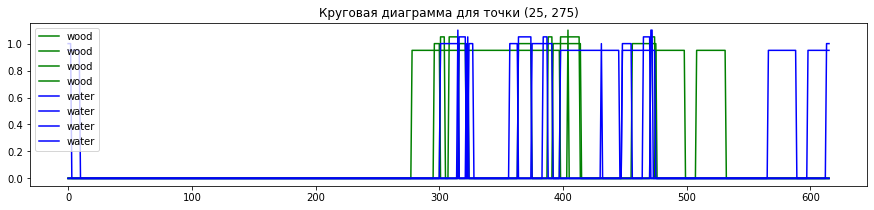

In [193]:
draw_sectors(img_cds.circle_diagrams[5].sectors, shift=0.0, title='Круговая диаграмма для точки (25, 275)')

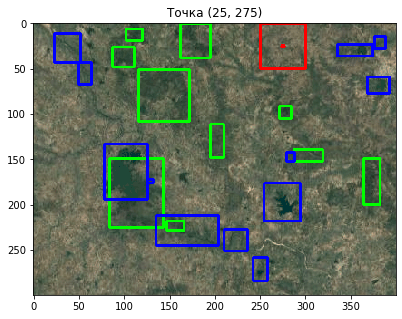

In [194]:
plt.figure(figsize=(12, 5))

img_copy_copy = img_copy.copy()
cv2.circle(img_copy_copy, (int(center_point[1]), int(center_point[0])), 3, (0, 0, 255), -1) 

bigger_side = img_copy.shape[1]
one_block_len = bigger_side / bigger_side_blocks_count
half = one_block_len / 2

cv2.rectangle(img_copy_copy,
             (int(center_point[1] - half), int(center_point[0] - half)),
             (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
plt.title('Точка (25, 275)')
plt.imshow(cv2.cvtColor(img_copy_copy, cv2.COLOR_BGR2RGB))

plt.show()

#### Построение круговой диаграммы агента

In [332]:
print(point)
POINT = point

(231, 316)


In [333]:
agent_point = POINT
agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm, with_angle_penalty=True)

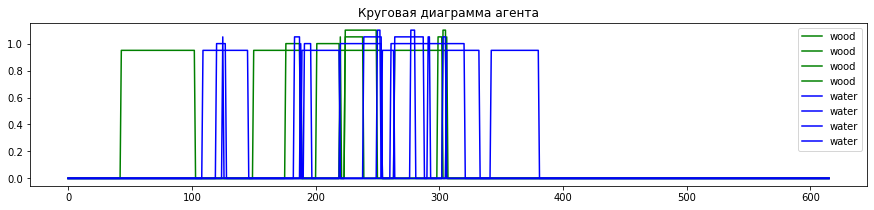

In [334]:
draw_sectors(agent_cd.sectors, shift=0.0, title='Круговая диаграмма агента')

### Сетка уверенностей

In [335]:
def calculate_cells_probs(img_cds, agent_cd):
    penalties = []
    
    for i in range(len(img_cds.center_points)):
        penalties.append(calculate_penalty_for_diagrams(img_cds.circle_diagrams[i].sectors, agent_cd.sectors))
        
    # Добавл. 1e-8 чтобы не было нулей
    similaryties = np.max(penalties) - penalties + 1e-8

    return similaryties / similaryties.sum()


def find_center_point_id(center_points, agent_point):
    for i in range(len(center_points)):
        if center_points[i] == agent_point:
            return i

In [336]:
cell_probs = calculate_cells_probs(img_cds, agent_cd)

In [337]:
def show_example(agent_point):
    # img_copy содержит прямоугольные границы объектов
    img_copy_copy = img_copy.copy()
    
    plt.figure(figsize=(14, 7))
    
    plt.subplot(121)
    cv2.circle(img_copy_copy, (agent_point[1], agent_point[0]), 3, (0, 0, 255), -1) 
    plt.title('Прямоугольные границы с местоположением агента')
    plt.imshow(cv2.cvtColor(img_copy_copy, cv2.COLOR_BGR2RGB))
    
    max_proba_point_id = np.argmax(cell_probs)
    max_center_point = img_cds.center_points[max_proba_point_id]

    probs = cell_probs.reshape((6, 8))
    probs_img = np.repeat(np.repeat(probs,
                            one_block_len
                            , axis=0),
                  one_block_len,
                  axis=1).reshape(img.shape[:2])
    points_color = np.min(probs_img)
    cv2.rectangle(probs_img,
         (int(max_center_point[1] - half), int(max_center_point[0] - half)),
         (int(max_center_point[1] + half), int(max_center_point[0] + half)), points_color, 2)
    cv2.circle(probs_img, (agent_point[1], agent_point[0]), 3, points_color, -1)
    
    plt.subplot(122)
    plt.title('Сетка уверенностей')
    plt.imshow(probs_img)
    
    plt.show()
    
    
    # Круговая диаграмма для агента + круговая диаграмма для выбранного квадрата
    draw_sectors(agent_cd.sectors, shift=0.0, title='Круговая диаграмма агента')
    draw_sectors(img_cds.circle_diagrams[max_proba_point_id].sectors, shift=0.0,
                 title='Круговая диаграмма центра выбранного квадрата')

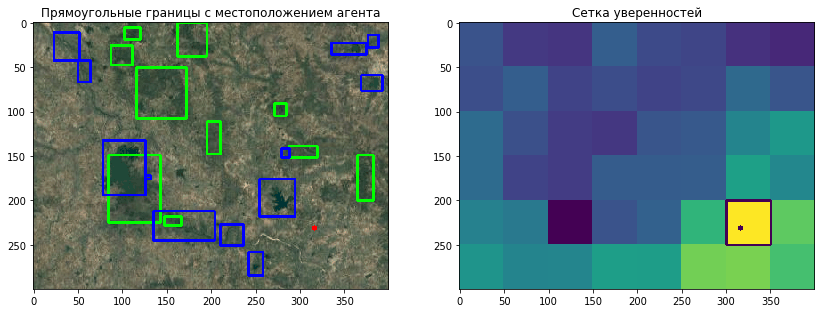

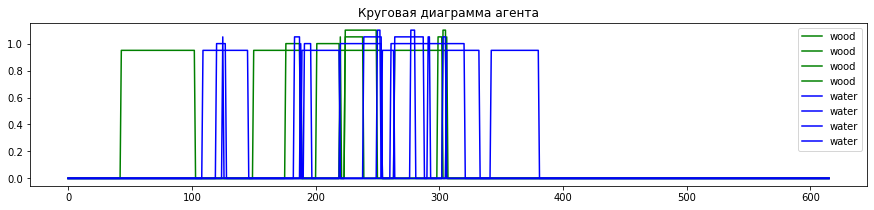

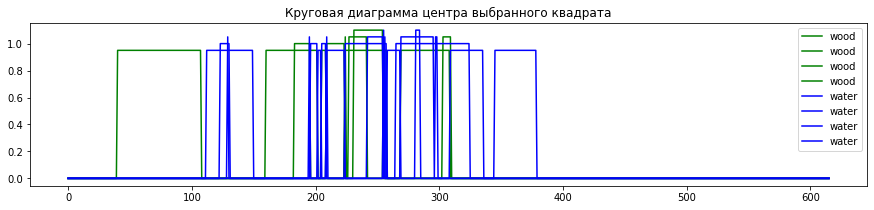

In [338]:
show_example(agent_point)

### Другие точки

In [379]:
import random

x = random.randint(0, 300)
y = random.randint(0, 400)

In [380]:
# X - высота (0, 300), Y - ширина (0, 400)
POINT = (x, y)
print(POINT)

(85, 330)


In [381]:
agent_point = POINT
agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm, with_angle_penalty=True)

In [382]:
cell_probs = calculate_cells_probs(img_cds, agent_cd)

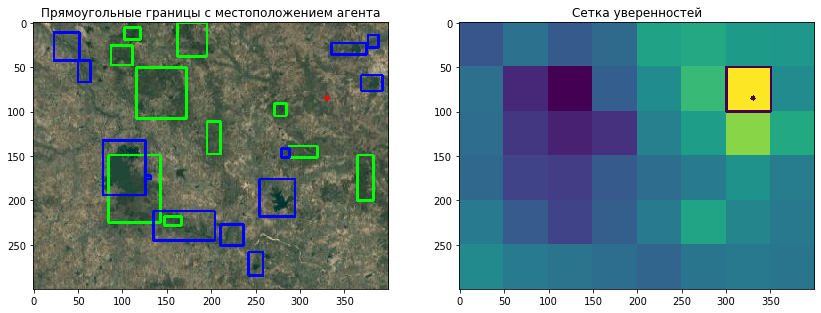

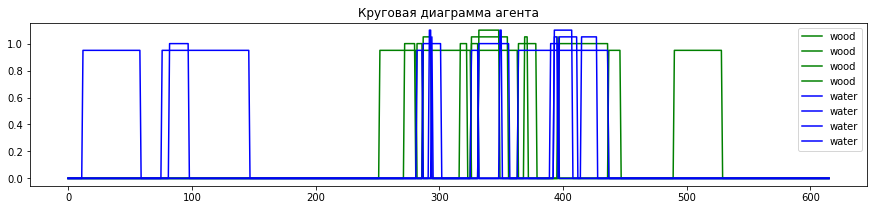

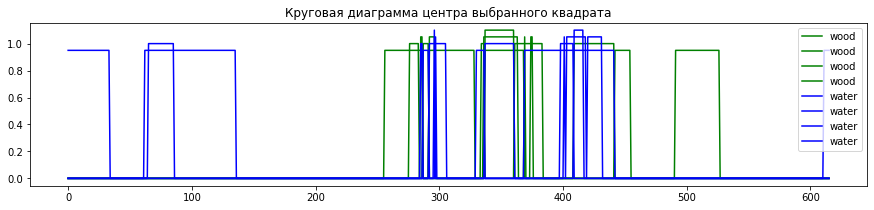

In [383]:
show_example(agent_point)